# start

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmocean.cm as cmo
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.colors as cl

import warnings
warnings.filterwarnings('ignore')

In [2]:
def rolling_(df):
    lol=pd.DataFrame(df).interpolate(limit=5, axis=1).interpolate(limit=5, axis=0).rolling(1, center=True, axis=1).mean()
    return lol.to_numpy()

def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return rolling_(grid),XI.T,YI.T

ds_bath=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2024_n35.0_s-10.0_w25.0_e85.0.nc')

# functions for gridding and extracting variables

In [3]:
## GRID 3d 4d
GS=1
latt=np.arange(-5,30+GS,GS)
lonn=np.arange(30,80+GS,GS)
# grid 3d for 3d variables (2d + time)

## grid pwp sum
def grid_lat_3dsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).sum(skipna=True) #,dim='profile_num')

def grid_lon_3d_sum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dsum)
    
    
def grid_var_3dsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_sum)
    else:
        var = dsvar.groupby('time.'+clim).apply(grid_lon_3d_sum)
    return var


## grid pwp sum
def grid_lat_3d(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).median(skipna=True) #,dim='profile_num')

def grid_lon_3d_(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3d)
    
    
def grid_var_3d(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'climat':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_)
    else:
        var = dsvar.groupby('time.'+clim).apply(grid_lon_3d_)
    return var

## GRID 3d 4d
# def mode_func(array):
#     mode_result = stats.mode(array, axis=None)
#     return mode_result.mode[0]

# grid 3d for 3d variables (2d + time)
def grid_lat_3df(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).median(skipna=True) #,dim='profile_num')
    
def grid_lon_3d_f(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3df)
    
    
def grid_var_3dflt(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'climat':
        var = dsvar.groupby_bins(group='time_f.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_f)
    else:
        var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_f)
    return var


# grid 3d for 3d variables (2d + time)
def grid_lat_3dfsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).sum(skipna=True) #,dim='profile_num')
    
def grid_lon_3d_fsum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dfsum)
    
    
def grid_var_3dfltsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time_f.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_fsum)
    else:
        var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_fsum)
    return var


#####333


def ds_get_float_pwp_3D(variable):
    df_t=xr.open_dataset(files[0]).expand_dims('platform_num_f')    
    df_t['latitude_f']=df_t.latitude_f.mean('pressure_f')
    df_t['longitude_f']=df_t.longitude_f.mean('pressure_f')
        
    ds_all=df_t[[variable, variable+'_f', 'latitude_f', 'longitude_f']]
    for i in tqdm(range(1, len(files))):
        df_t=xr.open_dataset(files[i]).expand_dims('platform_num_f')
        df_t['latitude_f']=df_t.latitude_f.mean('pressure_f')
        df_t['longitude_f']=df_t.longitude_f.mean('pressure_f')
        
        new_=df_t[[variable, variable+'_f', 'latitude_f', 'longitude_f']]
        
        ds_all=xr.combine_nested([ds_all, new_], concat_dim='platform_num_f')
    return ds_all

def ds_get_float_pwp_1D(variable):   
  
    df_t=xr.open_dataset(files[0])   
    if variable=='mw_thickness':
        df_t['mw_thickness']=df_t.bot_mwl-df_t.top_mwl
        df_t['mw_thickness_f']=df_t.bot_mwl_f-df_t.top_mwl_f
        
    if variable=='presence_mwl':
        df_t=_set_presence_mwl(df_t)
        
    df_t['latitude_f']=df_t.latitude_f.mean('pressure_f')
    df_t['longitude_f']=df_t.longitude_f.mean('pressure_f')
    
    df_t=df_t.expand_dims('platform_num_f')
    ds_all=df_t[[variable, variable+'_f', 'latitude_f', 'longitude_f']]
    for i in tqdm(range(1, len(files))):
        df_t=xr.open_dataset(files[i])
        
        if variable=='mw_thickness':
            df_t['mw_thickness']=df_t.bot_mwl-df_t.top_mwl
            df_t['mw_thickness_f']=df_t.bot_mwl_f-df_t.top_mwl_f
        if variable=='presence_mwl':
            df_t=_set_presence_mwl(df_t)
        df_t=df_t.expand_dims('platform_num_f')
        
        df_t['latitude_f']=df_t.latitude_f.mean('pressure_f')
        df_t['longitude_f']=df_t.longitude_f.mean('pressure_f')
        
        new_=df_t[[variable, variable+'_f', 'latitude_f', 'longitude_f']]
        
        ds_all=xr.combine_nested([ds_all, new_], concat_dim='platform_num_f')
    return ds_all

##  Load variables

In [4]:
# df_mwt=ds_get_float_pwp_1D('mw_thickness')
df_mwt=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/thickness_mw.nc')# df_mwt=ds_get_float_pwp_1D('mw_thickness')
df_mw_top=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/top_mw.nc').set_coords(['latitude_f', 'longitude_f'])# df_mwt=ds_get_float_pwp_1D('mw_thickness')
# df_mw_bot=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/bot_mw.nc')

# df_n2=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/all_n2_mw.nc')# df_mwt=ds_get_float_pwp_1D('mw_thickness')
# df_core_depth=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/min_n2_depth.nc')# df_mwt=ds_get_float_pwp_1D('mw_thickness')
# df_core_density=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/core_potential_density.nc')# df_mwt=ds_get_float_pwp_1D('mw_thickness')

df_mld=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/mld.nc').set_coords(['latitude_f', 'longitude_f'])

df_presence=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/presence_mw.nc')
df_presence=df_presence.sortby('platform_num_f')
df_presence['lat_pp']=df_presence.latitude_f.mean('time_f')
df_presence['lon_pp']=df_presence.longitude_f.mean('time_f')

## only foramtion
dff_presence_1 = df_presence.where(df_presence != 0, np.nan)
dff_presence_1 = dff_presence_1.where(df_presence != 2, np.nan)

## only duration
dff_presence_2 = df_presence.where(df_presence != 0, np.nan)
dff_presence_2 = dff_presence_2.where(df_presence != 1, np.nan)
dff_presence_2 = dff_presence_2.where(df_presence !=2, 1)

# no mode water
dff_presence_0 = df_presence.where(df_presence != 1, np.nan)
dff_presence_0 = dff_presence_0.where(df_presence != 2, np.nan)
dff_presence_0 = dff_presence_0.where(df_presence!=0, 1)


mask_pres=((dff_presence_0.presence_mwl_f.fillna(0).values+dff_presence_1.presence_mwl_f.fillna(0).values)==1).astype(float)
mask_pres[mask_pres==0]=np.nan

mask_thic=(df_mwt.mw_thickness_f>10).values.astype(float)
mask_thic[mask_thic==0]=np.nan

### TOPAZ

In [5]:
ds_topaz=xr.open_dataset('/home/jupyter-estelfont/common/fridge/TOPAZ_AS_2000_2020/TOPAZ_AS_2000_2020_z_0_250m.nc')
pressure_broadcasted = np.transpose(np.broadcast_to(ds_topaz.pressure, (2541, 120, 181, 27)), (0, 3, 1, 2))
ds_topaz['pressure_grid']=(('time', 'pressure', 'latitude', 'longitude'), pressure_broadcasted)
# 
ds_topaz_n2_mld=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_topaz/tropaz_n2_mld_0.125_2m.nc')
ds_topaz_n2_mld2=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_topaz/tropaz_n2_mld.nc')
ds_topaz_n2_mld=ds_topaz_n2_mld.rename({'mixed_layer_depth':'mixed_layer_depth_0125'})
ds_topaz_mwd=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_topaz/tropaz_mwl.nc')

ds_topaz=xr.merge([ds_topaz, ds_topaz_n2_mld, ds_topaz_n2_mld2, ds_topaz_mwd])

del ds_topaz_n2_mld, ds_topaz_mwd

ds_topaz['mw_thickness']=ds_topaz.bot_mwl-ds_topaz.top_mwl

seas=['DJF', 'JJA', 'MAM', 'SON']

dff_presence_1_topaz = ds_topaz.presence_mwl.where(ds_topaz.presence_mwl != 0, np.nan)
dff_presence_1_topaz = dff_presence_1_topaz.where(ds_topaz.presence_mwl != 2, np.nan)

## only duration
dff_presence_2_topaz = ds_topaz.presence_mwl.where(ds_topaz.presence_mwl != 0, np.nan)
dff_presence_2_topaz = dff_presence_2_topaz.where(ds_topaz.presence_mwl != 1, np.nan)
dff_presence_2_topaz = dff_presence_2_topaz.where(ds_topaz.presence_mwl !=2, 1)

# no mode water
dff_presence_0_topaz = ds_topaz.presence_mwl.where(ds_topaz.presence_mwl != 1, np.nan)
dff_presence_0_topaz = dff_presence_0_topaz.where(ds_topaz.presence_mwl != 2, np.nan)
dff_presence_0_topaz = dff_presence_0_topaz.where(ds_topaz.presence_mwl !=0, 1)

mskk_topaz=np.nansum([dff_presence_1_topaz.values, dff_presence_0_topaz.values], axis=0)
mskk_topaz[mskk_topaz==0]=np.nan

mask_thictopaz=(ds_topaz.mw_thickness>10).values.astype(float)
mask_thictopaz[mask_thictopaz==0]=np.nan

In [6]:
## GOTM
#load data
df_mld_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/mixed_layer_depth_gotm_all.nc').set_coords(['latitude', 'longitude'])
df_mwt_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/mw_thickness_gotm_all.nc').set_coords(['latitude', 'longitude'])

df_presence_gotm=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/presence_mwl_gotm_all.nc')
df_presence_gotm['lat_pp']=df_presence_gotm.latitude.mean('time')
df_presence_gotm['lon_pp']=df_presence_gotm.longitude.mean('time')
## only foramtion
dff_presence_1_gtm = df_presence_gotm.where(df_presence_gotm != 0, np.nan)
dff_presence_1_gtm = dff_presence_1_gtm.where(df_presence_gotm != 2, np.nan)
## only duration
dff_presence_2_gtm = df_presence_gotm.where(df_presence_gotm != 0, np.nan)
dff_presence_2_gtm = dff_presence_2_gtm.where(df_presence_gotm != 1, np.nan)
dff_presence_2_gtm = dff_presence_2_gtm.where(df_presence_gotm !=2, 1)
# no mode water
dff_presence_0_gtm = df_presence_gotm.where(df_presence_gotm != 1, np.nan)
dff_presence_0_gtm = dff_presence_0_gtm.where(df_presence_gotm != 2, np.nan)
dff_presence_0_gtm = dff_presence_0_gtm.where(df_presence_gotm!=0, 1)

mask_pres_gtm=((dff_presence_0_gtm.presence_mwl.fillna(0).values+dff_presence_1_gtm.presence_mwl.fillna(0).values)==1).astype(float)
mask_pres_gtm[mask_pres_gtm==0]=np.nan

mask_thic_gtm=(df_mwt_gotm.mw_thickness>10).values.astype(float)
mask_thic_gtm[mask_thic_gtm==0]=np.nan

## topaz collcoate to floats!

In [7]:
## MLD COLLOCATE!!"
dff_mld_float=df_mld.isel(platform_num_f=0).mixed_layer_depth_f.dropna('time_f').rename({'time_f':'time'})
time_axis=dff_mld_float.time

float_era5=ds_topaz.mixed_layer_depth.interp_like('time'==time_axis)
_lat=dff_mld_float.latitude_f#.interp_like('time'==float_era5.time)
_lon=dff_mld_float.longitude_f#.interp_like('time'==float_era5.time)

ds_all_topaz_coll=float_era5.sel(latitude=_lat, longitude=_lon, method='nearest').drop_vars(['latitude_f', 'longitude_f']).expand_dims('platform_num_f').reset_coords(names=['latitude', 'longitude'])

ds_all_topaz_coll['mld_float']=dff_mld_float

for i in tqdm(range(1, len(df_mld.platform_num_f))):
    dff_mld_float=df_mld.isel(platform_num_f=i).mixed_layer_depth_f.dropna('time_f').rename({'time_f':'time'})
    time_axis=dff_mld_float.time
    # print(i, len(time_axis))
    float_era5=ds_topaz.mixed_layer_depth.interp_like('time'==time_axis)
    if len(float_era5.time)<1:
        print('time > 2020!', i, time_axis[0], time_axis[-1])    
    else:
        #collocate to lat lon floats (NOT TIME)  .latitude_f
        _lat=dff_mld_float.latitude_f#.interp_like('time'==float_era5.time)
        # _lon=dff_mld_float.longitude_f.interp_like('time'==float_era5.time).ffill('time')
        _lon=dff_mld_float.longitude_f#.interp_like('time'==float_era5.time)
        float_era51=float_era5.sel(latitude=_lat, longitude=_lon, method='nearest').drop_vars(['latitude_f', 'longitude_f']).expand_dims('platform_num_f').reset_coords(names=['latitude', 'longitude'])
        float_era51['mld_float']=dff_mld_float

        ds_all_topaz_coll=xr.concat([ds_all_topaz_coll, float_era51], dim='platform_num_f')

  0%|          | 0/578 [00:00<?, ?it/s]

In [8]:
dff_mld_float=df_mld.isel(platform_num_f=0).mixed_layer_depth_f.dropna('time_f').rename({'time_f':'time'})
time_axis=dff_mld_float.time

float_era5=ds_topaz.mw_thickness.sel(time=slice(time_axis[0], time_axis[-1]))
#collocate to lat lon floats (NOT TIME)  .latitude_f
_lat=dff_mld_float.latitude_f.interp_like('time'==float_era5.time)
# _lon=dff_mld_float.longitude_f.interp_like('time'==float_era5.time).ffill('time')
_lon=dff_mld_float.longitude_f.interp_like('time'==float_era5.time)
ds_all_topaz_coll_mwt=float_era5.sel(latitude=_lat, longitude=_lon, method='nearest').drop_vars(['latitude_f', 'longitude_f']).expand_dims('platform_num_f').reset_coords(names=['latitude', 'longitude'])

for i in tqdm(range(1, len(df_mld.platform_num_f))):
    dff_mld_float=df_mld.isel(platform_num_f=i).mixed_layer_depth_f.dropna('time_f').rename({'time_f':'time'})
    time_axis=dff_mld_float.time
    # print(i, len(time_axis))
    float_era5=ds_topaz.mw_thickness.sel(time=slice(time_axis[0], time_axis[-1]))
    if len(float_era5.time)<1:
        print('time > 2020!')#, i, time_axis[0], time_axis[-1])    
    else:
        #collocate to lat lon floats (NOT TIME)  .latitude_f
        _lat=dff_mld_float.latitude_f.interp_like('time'==float_era5.time)
        # _lon=dff_mld_float.longitude_f.interp_like('time'==float_era5.time).ffill('time')
        _lon=dff_mld_float.longitude_f.interp_like('time'==float_era5.time)
        float_era51=float_era5.sel(latitude=_lat, longitude=_lon, method='nearest').drop_vars(['latitude_f', 'longitude_f']).expand_dims('platform_num_f').reset_coords(names=['latitude', 'longitude'])

        ds_all_topaz_coll_mwt=xr.concat([ds_all_topaz_coll_mwt, float_era51], dim='platform_num_f')

dff_mld_float=df_mld.isel(platform_num_f=0).mixed_layer_depth_f.dropna('time_f').rename({'time_f':'time'})        
time_axis=dff_mld_float.time

float_era5=ds_topaz.presence_mwl.sel(time=slice(time_axis[0], time_axis[-1]))
#collocate to lat lon floats (NOT TIME)  .latitude_f
_lat=dff_mld_float.latitude_f.interp_like('time'==float_era5.time)
# _lon=dff_mld_float.longitude_f.interp_like('time'==float_era5.time).ffill('time')
_lon=dff_mld_float.longitude_f.interp_like('time'==float_era5.time)
ds_all_topaz_collpresence=float_era5.sel(latitude=_lat, longitude=_lon, method='nearest').drop_vars(['latitude_f', 'longitude_f']).expand_dims('platform_num_f').reset_coords(names=['latitude', 'longitude'])

for i in tqdm(range(1, len(df_mld.platform_num_f))):
    dff_mld_float=df_mld.isel(platform_num_f=i).mixed_layer_depth_f.dropna('time_f').rename({'time_f':'time'})
    time_axis=dff_mld_float.time
    # print(i, len(time_axis))
    float_era5=ds_topaz.presence_mwl.sel(time=slice(time_axis[0], time_axis[-1]))
    if len(float_era5.time)<1:
        print('time > 2020!')#, i, time_axis[0], time_axis[-1])    
    else:
        #collocate to lat lon floats (NOT TIME)  .latitude_f
        _lat=dff_mld_float.latitude_f.interp_like('time'==float_era5.time)
        # _lon=dff_mld_float.longitude_f.interp_like('time'==float_era5.time).ffill('time')
        _lon=dff_mld_float.longitude_f.interp_like('time'==float_era5.time)
        float_era51=float_era5.sel(latitude=_lat, longitude=_lon, method='nearest').drop_vars(['latitude_f', 'longitude_f']).expand_dims('platform_num_f').reset_coords(names=['latitude', 'longitude'])

        ds_all_topaz_collpresence=xr.concat([ds_all_topaz_collpresence, float_era51], dim='platform_num_f')

  0%|          | 0/578 [00:00<?, ?it/s]

time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!


  0%|          | 0/578 [00:00<?, ?it/s]

time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!
time > 2020!


### EVALUATION BIAS

In [9]:
# from matplotlib.gridspec import GridSpec
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
monthss = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

alp=0.5

DJF   mean =-21 m  and  median=-19 m
MAM   mean =-9 m  and  median=-5 m
JJA   mean =-3 m  and  median=-3 m
SON   mean =-6 m  and  median=-5 m


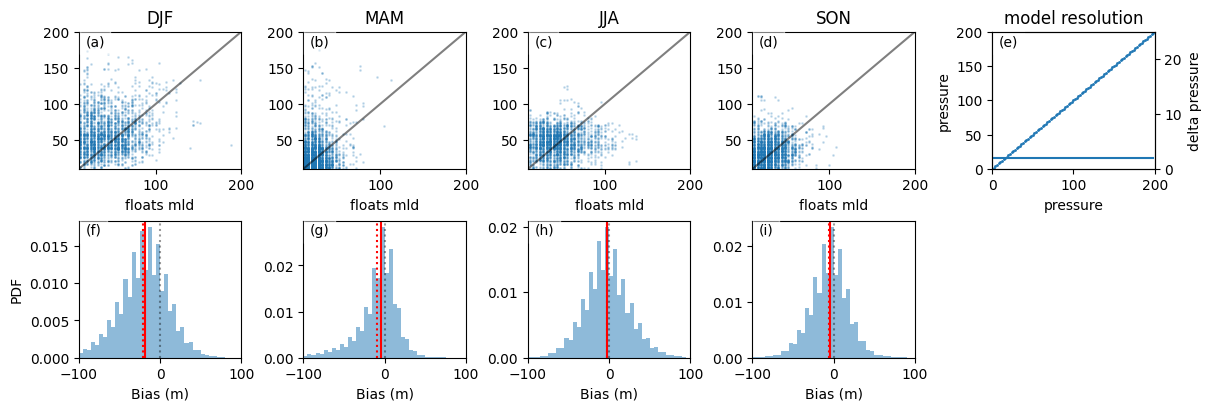

In [10]:
plt.figure(figsize=(12,4), constrained_layout=True)

time_axis=df_mld.rename({'time_f':'time'}).time
df_mld_gotm_to_float_time=df_mld_gotm.mixed_layer_depth.interp_like('time'==time_axis)

for i, m in enumerate( ['DJF', 'MAM', 'JJA', 'SON']):
    ax=plt.subplot(251+i)
    t=ax.text(x=.04,y=.9,s="(" + letters[i] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

    plt.title(m)
    # x, y=ds_all_topaz_coll.mld_float.groupby('time.season')[m].values.flatten(), ds_all_topaz_coll.mixed_layer_depth.groupby('time.season')[m].values.flatten()
    x, y=df_mld.mixed_layer_depth_f.groupby('time_f.season')[m].values.flatten(), df_mld_gotm_to_float_time.groupby('time.season')[m].values.flatten()
    plt.scatter(x,y, s=1, alpha=.2)
    plt.plot([10,250], [10,250], c='k', alpha=0.5)
    plt.ylim(10,200)
    plt.xlim(10,200)
    if m==0:
        plt.ylabel('1D model mld')
    plt.xlabel('floats mld')

ax=plt.subplot(255)
t=ax.text(x=.04,y=.9,s="(" + letters[4] + ')',transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

plt.title('model resolution')
plt.scatter(np.arange(0,200,2), np.arange(0,200,2), s=1)
plt.ylim(0, 200)
plt.xlim(0,200)
plt.xlabel('pressure')
plt.ylabel('pressure')
plt.twinx()
plt.plot(np.arange(0,200,2), np.ones(len(np.arange(0,200,2)))*2)
plt.ylim(0,25)
plt.ylabel('delta pressure')

for m, i in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax=plt.subplot(251+m+5)
    t=ax.text(x=.04,y=.9,s="(" + letters[m+5] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    bis=(df_mld.mixed_layer_depth_f.groupby('time_f.season')[i]-df_mld_gotm.mixed_layer_depth.groupby('time.season')[i]).values.flatten()
    _=plt.hist(bis, bins=np.arange(-100,100,5), density=True, alpha=0.5)
    plt.xlim(-100,100)
    plt.axvline(0, c='k', ls=':', alpha=0.4)
    plt.axvline(np.nanmean(bis), c='r', ls=':')
    plt.axvline(np.nanmedian(bis), c='r')

    # plt.title(i)#+'  mean ='+str(round(np.nanmean((ds_all_topaz_coll.mld_float.groupby('time.season')[i]-ds_all_topaz_coll.mixed_layer_depth).values.flatten())))+' m')
    print(i+'   mean ='+str(round(np.nanmean(bis)))+' m  and  median='+str(round(np.nanmedian(bis)))+' m')
    # plt.text(50,0.01, 'mean ='+str(round(np.nanmean((ds_all_topaz_coll.mld_float.groupby('time.season')[i]-ds_all_topaz_coll.mixed_layer_depth).values.flatten())))+' m')
    plt.xlabel('Bias (m)')
    if m==0:
        plt.ylabel('PDF')
        
plt.savefig('Figures/SFigure_MLDbias_GOTM.png', dpi=600, bbox_inches='tight')    

In [280]:
for m, i in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    bis=(df_mld.mixed_layer_depth_f.groupby('time_f.season')[i]-df_mld_gotm.mixed_layer_depth.groupby('time.season')[i]).values.flatten()
    print(i+'   std ='+str(np.nanstd(bis)))

DJF   std =30.581077110649222
MAM   std =25.900335462884005
JJA   std =27.95152776631337
SON   std =24.76143282668744


DJF   mean =-20 m  and  median=-17 m
MAM   mean =-9 m  and  median=-8 m
JJA   mean =-10 m  and  median=-8 m
SON   mean =-11 m  and  median=-11 m


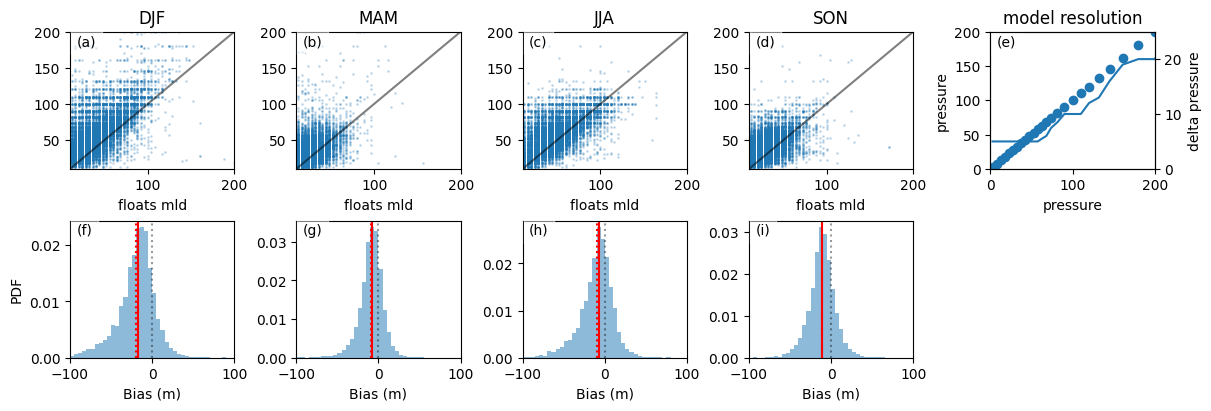

In [11]:
plt.figure(figsize=(12,4), constrained_layout=True)

for i, m in enumerate( ['DJF', 'MAM', 'JJA', 'SON']):
    ax=plt.subplot(251+i)
    t=ax.text(x=.04,y=.9,s="(" + letters[i] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

    plt.title(m)
    x, y=ds_all_topaz_coll.mld_float.groupby('time.season')[m].values.flatten(), ds_all_topaz_coll.mixed_layer_depth.groupby('time.season')[m].values.flatten()

    plt.scatter(x,y, s=1, alpha=.2)
    plt.plot([10,250], [10,250], c='k', alpha=0.5)
    plt.ylim(10,200)
    plt.xlim(10,200)
    plt.xlabel('floats mld')
    if m==0:
        plt.ylabel('3d model mld')

    # mask = ~np.isnan(x) & (x>20)  & ~np.isnan(y) & (y>20)
    # X, Y= x[mask], y[mask]
    # slope, intercept, r_value, p_value, std_err = linregress(X, Y)
    # regression_line = slope * np.arange(20,100) + intercept
    # plt.plot(np.arange(20,100), regression_line, color='red', label=f'y={slope:.2f}x + {intercept:.2f} \nr={r_value:.2f}')
    # plt.legend()
    # print(p_value)


ax=plt.subplot(255)
t=ax.text(x=.04,y=.9,s="(" + letters[4] + ')',transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

plt.title('model resolution')
plt.scatter(ds_topaz.pressure, ds_topaz.pressure)
plt.ylim(0, 200)
plt.xlim(0,200)
plt.xlabel('pressure')
plt.ylabel('pressure')
plt.twinx()
plt.plot(ds_topaz.pressure[:-1], ds_topaz.pressure.diff('pressure'))
plt.ylim(0,25)
plt.ylabel('delta pressure')

for m, i in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax=plt.subplot(251+m+5)
    t=ax.text(x=.04,y=.9,s="(" + letters[m+5] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

    _=plt.hist((ds_all_topaz_coll.groupby('time.season')[i].mld_float-ds_all_topaz_coll.mixed_layer_depth.groupby('time.season')[i]).values.flatten(), bins=np.arange(-100,100,5), density=True, alpha=0.5)
    plt.xlim(-100,100)
    plt.axvline(0, c='k', ls=':', alpha=0.4)
    plt.axvline(np.nanmean((ds_all_topaz_coll.mld_float.groupby('time.season')[i]-ds_all_topaz_coll.mixed_layer_depth.groupby('time.season')[i]).values.flatten()), c='r', ls=':')
    plt.axvline(np.nanmedian((ds_all_topaz_coll.mld_float.groupby('time.season')[i]-ds_all_topaz_coll.mixed_layer_depth.groupby('time.season')[i]).values.flatten()), c='r')

    # plt.title(i)#+'  mean ='+str(round(np.nanmean((ds_all_topaz_coll.mld_float.groupby('time.season')[i]-ds_all_topaz_coll.mixed_layer_depth).values.flatten())))+' m')
    print(i+'   mean ='+str(round(np.nanmean((ds_all_topaz_coll.mld_float.groupby('time.season')[i]-ds_all_topaz_coll.mixed_layer_depth).values.flatten())))+' m  and  median='+str(round(np.nanmedian((ds_all_topaz_coll.mld_float.groupby('time.season')[i]-ds_all_topaz_coll.mixed_layer_depth).values.flatten())))+' m')
    # plt.text(50,0.01, 'mean ='+str(round(np.nanmean((ds_all_topaz_coll.mld_float.groupby('time.season')[i]-ds_all_topaz_coll.mixed_layer_depth).values.flatten())))+' m')
    plt.xlabel('Bias (m)')
    if m==0:
        plt.ylabel('PDF')
        
plt.savefig('Figures/SFigure_MLDbias_MOM4p1TOPAZ.png', dpi=600, bbox_inches='tight')    

In [281]:
for m, i in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    print(i+'   mean ='+str(np.nanstd((ds_all_topaz_coll.mld_float.groupby('time.season')[i]-ds_all_topaz_coll.mixed_layer_depth).values.flatten())))

DJF   mean =24.327449541858883
MAM   mean =16.721844956369967
JJA   mean =20.245950555513385
SON   mean =16.93568950040254


## Gridding

### FLOAT

In [12]:
df_mld=df_mld.set_coords(['latitude_f', 'longitude_f'])
#season
df_grid_mld_f_season=grid_var_3dflt(df_mld.mixed_layer_depth_f, clim='season', gs=1) ##3min


#thicnkess
df_mwt=df_mwt.set_coords(['latitude_f', 'longitude_f'])
#month
df_grid_mwt_f_month=grid_var_3dflt(df_mwt.mw_thickness_f*mask_thic*mask_pres, clim='month', gs=1) ##3min
#season
df_grid_mwt_f_season=grid_var_3dflt(df_mwt.mw_thickness_f*mask_thic*mask_pres, clim='season', gs=1) ##3min


## presence
#season
dff_presence_1=dff_presence_1.set_coords(['latitude_f', 'longitude_f'])
dff_presence_1_f_grid_sum=grid_var_3dfltsum(dff_presence_1.presence_mwl_f, clim='season', gs=1)
dff_presence_2=dff_presence_2.set_coords(['latitude_f', 'longitude_f'])
dff_presence_2_f_grid_sum=grid_var_3dfltsum(dff_presence_2.presence_mwl_f, clim='season', gs=1) 
dff_presence_0=dff_presence_0.set_coords(['latitude_f', 'longitude_f'])
dff_presence_0_f_grid_sum=grid_var_3dfltsum(dff_presence_0.presence_mwl_f, clim='season', gs=1) 

percentage0_seas=dff_presence_0_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage1_seas=dff_presence_1_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage2_seas=dff_presence_2_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)

#month
dff_presence_1=dff_presence_1.set_coords(['latitude_f', 'longitude_f'])
dff_presence_1_f_grid_sum=grid_var_3dfltsum(dff_presence_1.presence_mwl_f, clim='month', gs=1) ##3min
dff_presence_2=dff_presence_2.set_coords(['latitude_f', 'longitude_f'])
dff_presence_2_f_grid_sum=grid_var_3dfltsum(dff_presence_2.presence_mwl_f, clim='month', gs=1) ##3min
dff_presence_0=dff_presence_0.set_coords(['latitude_f', 'longitude_f'])
dff_presence_0_f_grid_sum=grid_var_3dfltsum(dff_presence_0.presence_mwl_f, clim='month', gs=1) ##3min

percentage0_mn=dff_presence_0_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage1_mn=dff_presence_1_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)
percentage2_mn=dff_presence_2_f_grid_sum/(dff_presence_1_f_grid_sum+dff_presence_2_f_grid_sum+dff_presence_0_f_grid_sum)


## masking! --where there is data
msk=np.isfinite((percentage0_mn+percentage1_mn+percentage2_mn)).astype(float)
msk=msk.where(msk!=0, np.nan)
# msk
mskki=((percentage0_mn+percentage1_mn)>0.5).astype(float).values
mskki[mskki==0]=np.nan
# msk
mskki2=(df_grid_mwt_f_month>10).astype(float).values
mskki2[mskki2==0]=np.nan

mwt_msk_per_month=df_grid_mwt_f_month*mskki*mskki2*msk.values

## gotm

In [13]:
### mld
df_mld_gotm_grid=grid_var_3d(df_mld_gotm.mixed_layer_depth, clim='season', gs=1) ##3min

###  mwt
df_mwt_gotm_grid=grid_var_3d(df_mwt_gotm.mw_thickness*mask_pres_gtm*mask_thic_gtm, clim='season', gs=1) ##3min
df_mwt_gotm_grid_month=grid_var_3d(df_mwt_gotm.mw_thickness*mask_pres_gtm*mask_thic_gtm, clim='month', gs=1) ##3min

# presence
dff_presence_1_gtm=dff_presence_1_gtm.set_coords(['latitude', 'longitude'])
dff_presence_1_f_grid_sum_gtm=grid_var_3dsum(dff_presence_1_gtm.presence_mwl, clim='month', gs=1) ##3min

dff_presence_2_gtm=dff_presence_2_gtm.set_coords(['latitude', 'longitude'])
dff_presence_2_f_grid_sum_gtm=grid_var_3dsum(dff_presence_2_gtm.presence_mwl, clim='month', gs=1) ##3min

dff_presence_0_gtm=dff_presence_0_gtm.set_coords(['latitude', 'longitude'])
dff_presence_0_f_grid_sum_gtm=grid_var_3dsum(dff_presence_0_gtm.presence_mwl, clim='month', gs=1) ##3min

percentage0_mn_gtm=dff_presence_0_f_grid_sum_gtm/(dff_presence_1_f_grid_sum_gtm+dff_presence_2_f_grid_sum_gtm+dff_presence_0_f_grid_sum_gtm)
percentage1_mn_gtm=dff_presence_1_f_grid_sum_gtm/(dff_presence_1_f_grid_sum_gtm+dff_presence_2_f_grid_sum_gtm+dff_presence_0_f_grid_sum_gtm)
percentage2_mn_gtm=dff_presence_2_f_grid_sum_gtm/(dff_presence_1_f_grid_sum_gtm+dff_presence_2_f_grid_sum_gtm+dff_presence_0_f_grid_sum_gtm)

msk_gtm=np.isfinite((percentage0_mn_gtm+percentage1_mn_gtm+percentage2_mn_gtm)).astype(float)
msk_gtm=msk_gtm.where(msk_gtm!=0, np.nan)
# msk

mskki_gtm=((percentage0_mn_gtm+percentage1_mn_gtm)>0.5).astype(float).values
mskki_gtm[mskki_gtm==0]=np.nan

# msk
mskki2GTM=(df_mwt_gotm_grid_month>10).astype(float).values
mskki2GTM[mskki2GTM==0]=np.nan

mwt_msk_per_month_gtm=df_mwt_gotm_grid_month*mskki_gtm*mskki2GTM*msk_gtm.values

### TOPAZ


In [14]:
#season
ds_all_topaz_coll=ds_all_topaz_coll.set_coords(['latitude', 'longitude'])
ds_all_topaz_coll_mwt=ds_all_topaz_coll_mwt.set_coords(['latitude', 'longitude'])

ds_all_topaz_collpresence=ds_all_topaz_collpresence.set_coords(['latitude', 'longitude'])

dff_presence_1_topaz = ds_all_topaz_collpresence.presence_mwl.where(ds_all_topaz_collpresence.presence_mwl != 0, np.nan)
dff_presence_1_topaz = dff_presence_1_topaz.where(ds_all_topaz_collpresence.presence_mwl != 2, np.nan)
## only duration
dff_presence_2_topaz = ds_all_topaz_collpresence.presence_mwl.where(ds_all_topaz_collpresence.presence_mwl != 0, np.nan)
dff_presence_2_topaz = dff_presence_2_topaz.where(ds_all_topaz_collpresence.presence_mwl != 1, np.nan)
dff_presence_2_topaz = dff_presence_2_topaz.where(ds_all_topaz_collpresence.presence_mwl !=2, 1)
# no mode water
dff_presence_0_topaz = ds_all_topaz_collpresence.presence_mwl.where(ds_all_topaz_collpresence.presence_mwl != 1, np.nan)
dff_presence_0_topaz = dff_presence_0_topaz.where(ds_all_topaz_collpresence.presence_mwl != 2, np.nan)
dff_presence_0_topaz = dff_presence_0_topaz.where(ds_all_topaz_collpresence.presence_mwl !=0, 1)

mskk_topaz=np.nansum([dff_presence_1_topaz.values, dff_presence_0_topaz.values], axis=0)
mskk_topaz[mskk_topaz==0]=np.nan

mask_thictopaz=(ds_all_topaz_coll_mwt.mw_thickness>10).values.astype(float)
mask_thictopaz[mask_thictopaz==0]=np.nan

# grid
# ds_all_topaz_coll_grid_week=grid_var_3d(ds_all_topaz_coll.mixed_layer_depth, clim='week', gs=1) ##3min
ds_all_topaz_coll_grid=grid_var_3d(ds_all_topaz_coll.mixed_layer_depth, clim='season', gs=1) ##3min
ds_all_topaz_coll_grid_month=grid_var_3d(ds_all_topaz_coll.mixed_layer_depth, clim='month', gs=1) ##3min

ds_all_topaz_coll_grid_mwt=grid_var_3d(ds_all_topaz_coll_mwt.mw_thickness*mskk_topaz*mask_thictopaz, clim='season', gs=1) ##3min
ds_all_topaz_coll_grid_mwt_Month=grid_var_3d(ds_all_topaz_coll_mwt.mw_thickness*mskk_topaz*mask_thictopaz, clim='month', gs=1) ##3min

#presence
dff_presence_1_topaz_grid_sum=grid_var_3dsum(dff_presence_1_topaz, clim='month', gs=1) ##3min
dff_presence_2_topaz_grid_sum=grid_var_3dsum(dff_presence_2_topaz, clim='month', gs=1) ##3min
dff_presence_0_topaz_grid_sum=grid_var_3dsum(dff_presence_0_topaz, clim='month', gs=1) ##3min

percentage0_seastopaz=dff_presence_0_topaz_grid_sum/(dff_presence_1_topaz_grid_sum+dff_presence_2_topaz_grid_sum+dff_presence_0_topaz_grid_sum)
percentage1_seastopaz=dff_presence_1_topaz_grid_sum/(dff_presence_1_topaz_grid_sum+dff_presence_2_topaz_grid_sum+dff_presence_0_topaz_grid_sum)
percentage2_seastopaz=dff_presence_2_topaz_grid_sum/(dff_presence_1_topaz_grid_sum+dff_presence_2_topaz_grid_sum+dff_presence_0_topaz_grid_sum)


msk=np.isfinite((percentage0_seastopaz+percentage1_seastopaz+percentage2_seastopaz)).astype(float)
msk=msk.where(msk!=0, np.nan)
# msk
mskki=((percentage0_seastopaz+percentage1_seastopaz)>0.5).astype(float).values
mskki[mskki==0]=np.nan

# msk
mskki2TOPAZ=(ds_all_topaz_coll_grid_mwt_Month>10).astype(float).values
mskki2TOPAZ[mskki2TOPAZ==0]=np.nan

mwt_msk_per_month_topaz=ds_all_topaz_coll_grid_mwt_Month*mskki*mskki2TOPAZ*msk.values

## Figure 5 - PWP-float BIAS 

In [15]:
from scipy.interpolate import interp1d
def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
alp=0.5

GoO=[24, 58]
SAS=[12,62.5]
UPW=[18, 58]
EAS=[20,68]
SEAS=[14,71]
CAS=[18,62.5]

regions_names=['GoO', 'SAS', 'UPW', 'SEAS', 'CAS']
regions=[GoO, SAS, UPW, SEAS, CAS]
colors_regions=['k', 'r', 'green', 'lightblue', 'yellow']    


from matplotlib.colors import LinearSegmentedColormap
def get_cmap():
    """
    Create and return a custom colormap for visualizations.

    This function generates a linear segmented colormap that transitions through a specified 
    set of colors, ordered from dark red to dark blue. The colormap is defined using 
    hexadecimal color codes and is intended for use in visualizations where a smooth 
    transition between these colors is desired.

    Returns
    -------
    cmap : matplotlib.colors.LinearSegmentedColormap
        A custom colormap object that can be used in plotting functions to map data values 
        to colors.

    Notes
    -----
    - The colormap transitions through the following colors (in reverse order for the final colormap):
      '#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', 
      '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'.
    - The resulting colormap can be applied to any data visualization that supports colormaps, 
      such as those created with matplotlib.
    
    Example
    -------
    >>> cmap = get_cmap()
    >>> plt.imshow(data, cmap=cmap)
    >>> plt.colorbar()
    """
    
    # Define the colors in the order you've specified
    colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
    # Create a colormap that transitions from the first color to the last
    cmap_name = 'custom_cmap'
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors[::-1])
    return cmap

br=get_cmap()

#### FIg bias mld

0it [00:00, ?it/s]

0
(61.10507246376811, 13.656250833610878)
(55.7152841781874, 10.435369766684472)
sas (52.25, 8.901544809750721)
1
(17.676870748299322, 4.98585393028446)
(19.760518053375197, 3.5986458731095783)
sas (22.825, 3.991475291167415)
2
(24.004901960784313, 9.133606630922285)
(49.82764259549974, 20.98795828335699)
sas (78.9, 7.60032894024989)
3
(24.47340425531915, 6.672074632406881)
(26.212698412698415, 6.3267162569081625)
sas (29.95, 2.573421846491554)


0it [00:00, ?it/s]

0
(-27.455387205387204, 17.45138362978507)
(-13.535390946502057, 7.8682786106496)
all -18.033757422321536 11.725476455180754
soo (-12.0, 3.687371396934413)
eas (-38.22901234567902, 16.54808344465321)
sas (-16.38888888888889, 5.4426867911145544)
1
(-4.73404255319149, 4.634456782946496)
(-3.0876068376068386, 4.327595178359399)
all -5.343520415311923 6.615699883634822
soo (-11.833333333333332, 4.196927153390227)
eas (-12.277777777777777, 11.57871270325247)
sas (-2.95, 1.8427284520916662)
2
(-2.344907407407408, 3.583242863007603)
(3.32925925925926, 14.216587324109572)
all -6.968278902697087 10.55035785386086
soo (-3.7037037037037037, 1.9091146620533144)
eas (-4.545454545454545, 8.429712634272818)
sas (19.63888888888889, 4.999861109182046)
3
(-4.012345679012346, 3.6225344273710065)
(-4.664550264550264, 5.1862881884819405)
all -7.504881724236416 7.114840500440485
soo (-3.888888888888889, 2.5204629904180345)
eas (-12.150462962962964, 7.188185092893631)
sas (-1.7833333333333332, 1.258783951691

0it [00:00, ?it/s]

0
(-33.53990514905149, 7.679608311648356)
(-25.51781517094017, 5.783501097095501)
all -20.024018493010278 9.41824792332769
soo (-37.31828703703704, 6.42174753998749)
eas (-28.01390993265993, 5.452039893318949)
sas (-22.508379629629626, 1.9319640584203732)
1
(-5.602874677002584, 3.714258093060428)
(-7.78834052499101, 3.9422788569998515)
all -7.744417804084998 3.473392552032896
soo (-11.229938271604938, 6.725880327715216)
eas (-11.875805152979067, 5.283268528452513)
sas (-5.18888888888889, 1.9779095531076103)
2
(-3.611111111111111, 3.250022170060816)
(-12.454274691358025, 7.535074467738713)
all -11.435274360271814 8.348480438467671
soo (-10.453703703703704, 2.5377972637681334)
eas (-7.6254208754208745, 4.9827914422285335)
sas (-6.044675925925928, 3.9813464326256423)
3
(-8.537247474747472, 4.694164470361912)
(-13.357301587301585, 3.440197034445431)
all -11.034333739501639 5.3205245568375945
soo (-13.641975308641975, 3.0431504013420416)
eas (-11.340141612200435, 5.228013801863229)
sas (-16

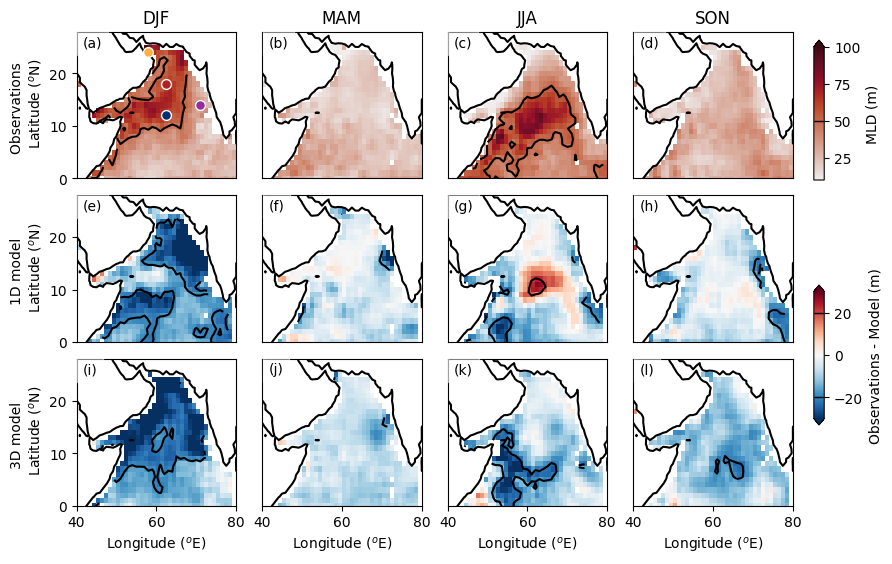

In [16]:
xx,yy=8,8
fig_sx, fig_sy=8,7

fig = plt.figure(figsize=(fig_sx, fig_sy), constrained_layout=True)
gs = GridSpec(xx,yy, figure=fig)
titles=df_grid_mwt_f_season.season.values

data_plt=(df_grid_mld_f_season.values)
axis_=[]
MLD_array=[]
for i,m in tqdm(enumerate([0,2,1,3])):
    # ax = fig.add_subplot(gs[ i % yy,i // yy])
    ax = fig.add_subplot(gs[0:2, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

    axis_.append(ax)
    ax.set_title(titles[m])
    data_m=data_plt[m]
    
    mks=np.isfinite(data_m.T).astype(float)
    mks[mks==0]=np.nan
    to_plt=pd.DataFrame(data_m.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(2, axis=0, center=True).mean().rolling(2, axis=1, center=True).mean()*mks
    MLD_array.append(to_plt)
    cb1=plt.pcolormesh(lonn, latt-GS/2, to_plt,  vmin=10, vmax=100, cmap=cmo.amp)
    plt.contour(lonn[:-1], latt[:-1]-GS/2, pd.DataFrame(data_m.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(2, axis=0, center=True).mean().rolling(2, axis=1, center=True).mean()*mks, levels=[50], colors='k', linestyles='-')

    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)

    print(i)
    # mskss=(~np.isfinite(mask_hatches/mask_hatches)).astype(float).where((~np.isfinite(mask_hatches/mask_hatches)).astype(float)==1, np.nan)
    lol1=np.nanmean(((to_plt.T).to_numpy()).T[25:,15:-10]),np.nanstd(((to_plt.T)).to_numpy().T[25:, 15:-10])
    lol2=np.nanmean(((to_plt.T).to_numpy()).T[15:25,15:-10]),np.nanstd(((to_plt.T)).to_numpy().T[15:25,15:-10])
    print(lol1)
    print(lol2)
    # loloman=np.nanmean(((to_plt.T).to_numpy()).T[14:22,28:35]),np.nanstd(((to_plt.T).to_numpy()).T[14:22,28:35])
    loloman=np.nanmean(((to_plt.T).to_numpy()).T[14:18,30:35]),np.nanstd(((to_plt.T).to_numpy()).T[14:18,30:35])
    
    print('sas', loloman )
    
data_plt=df_grid_mld_f_season.values-df_mld_gotm_grid.values
bias_MLD_1D_array=[]

for i,m in tqdm(enumerate([0,2,1,3])):
    # ax = fig.add_subplot(gs[ i % yy,i // yy])
    ax = fig.add_subplot(gs[2:4, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+4] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

    axis_.append(ax)

    data_m=data_plt[m]
    
    mks=np.isfinite(data_m.T).astype(float)
    mks[mks==0]=np.nan
    to_plt=pd.DataFrame(data_m.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks
    cb3=plt.pcolormesh(lonn, latt-GS/2, to_plt,   vmin=-30, vmax=30 ,cmap=br)
    plt.contour(lonn[:-1], latt[:-1]-GS/2, pd.DataFrame(data_m.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks,  levels=[-20,20], colors='k', linestyles='-')
    bias_MLD_1D_array.append(to_plt)

    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)

    print(i)
    # mskss=(~np.isfinite(mask_hatches/mask_hatches)).astype(float).where((~np.isfinite(mask_hatches/mask_hatches)).astype(float)==1, np.nan)
    lol1=np.nanmean(((to_plt.T).to_numpy()).T[25:,15:-10]),np.nanstd(((to_plt.T)).to_numpy().T[25:, 15:-10])
    lol2=np.nanmean(((to_plt.T).to_numpy()).T[15:20,15:-10]),np.nanstd(((to_plt.T)).to_numpy().T[15:20,15:-10])
    print(lol1)
    print(lol2)
    print('all', np.nanmean(((to_plt.T).to_numpy()).T),np.nanstd(((to_plt.T)).to_numpy().T))

    loloman=np.nanmean(((to_plt.T).to_numpy()).T[28:,26:31]),np.nanstd(((to_plt.T)).to_numpy().T[28:,26:31])
    print('soo', loloman )
    loloman=np.nanmean(((to_plt.T).to_numpy()).T[15:30,38:50]),np.nanstd(((to_plt.T).to_numpy()).T[15:30,38:50])
    print('eas', loloman )
    
    loloman=np.nanmean(((to_plt.T).to_numpy()).T[14:18,30:35]),np.nanstd(((to_plt.T).to_numpy()).T[14:18,30:35])
    print('sas', loloman )
    
    # xx,yy=np.meshgrid(lonn[30:35], latt[14:18]-GS/2)
    # plt.scatter(xx, yy, s=0.5)

    # [28:35], latt[14:22]
data_plt=df_grid_mld_f_season.values-(ds_all_topaz_coll_grid.values)
 
bias_MLD_3D_array=[]
for i,m in tqdm(enumerate([0,2,1,3])):
    # ax = fig.add_subplot(gs[ i % yy,i // yy])
    ax = fig.add_subplot(gs[4:6, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+8] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

    axis_.append(ax)

    data_m=data_plt[m]
    
    mks=np.isfinite(data_m.T).astype(float)
    mks[mks==0]=np.nan
    to_plt=pd.DataFrame(data_m.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks
    bias_MLD_3D_array.append(to_plt)
    
    cb3=plt.pcolormesh(lonn, latt-GS/2, to_plt,   vmin=-30, vmax=30 ,cmap=br)
    
    plt.contour(lonn[:-1], latt[:-1]-GS/2, pd.DataFrame(data_m.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks,  levels=[-20,20], colors='k', linestyles='-')
    
    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)
    print(i)
    # mskss=(~np.isfinite(mask_hatches/mask_hatches)).astype(float).where((~np.isfinite(mask_hatches/mask_hatches)).astype(float)==1, np.nan)
    lol1=np.nanmean(((to_plt.T).to_numpy()).T[25:,15:-10]),np.nanstd(((to_plt.T)).to_numpy().T[25:, 15:-10])
    lol2=np.nanmean(((to_plt.T).to_numpy()).T[15:20,15:-10]),np.nanstd(((to_plt.T)).to_numpy().T[15:20,15:-10])
    print(lol1)
    print(lol2)
    print('all', np.nanmean(((to_plt.T).to_numpy()).T),np.nanstd(((to_plt.T)).to_numpy().T))
    
    loloman=np.nanmean(((to_plt.T).to_numpy()).T[28:,26:31]),np.nanstd(((to_plt.T)).to_numpy().T[28:,26:31])
    print('soo', loloman )
    loloman=np.nanmean(((to_plt.T).to_numpy()).T[15:30,38:50]),np.nanstd(((to_plt.T).to_numpy()).T[15:30,38:50])
    print('eas', loloman )
    loloman=np.nanmean(((to_plt.T).to_numpy()).T[14:18,30:35]),np.nanstd(((to_plt.T).to_numpy()).T[14:18,30:35])
    print('sas', loloman )
cbar_ax = fig.add_axes([1.01, 0.75, 0.013, 0.2])  # left, bottom, width, height
cbar = plt.colorbar(cb1, cax=cbar_ax,  extend='max')
cbar.set_label('MLD (m)')
ax = cbar.ax
xmin, xmax = ax.get_xlim()
ax.hlines([50], xmin, xmax, colors=['black'], linewidth=1)


cbar_ax = fig.add_axes([1.01, 0.4, 0.013, 0.2])  # left, bottom, width, height
cbar = plt.colorbar(cb3, cax=cbar_ax,  extend='both')
cbar.set_label('Observations - Model (m)')
ax = cbar.ax
xmin, xmax = ax.get_xlim()
ax.hlines([-20,20], xmin, xmax, colors=['black'], linewidth=1)

axis_[0].set_ylabel('Observations \n Latitude ($^o$N)')

for i in range(8):
    axis_[i].set_xticks([])

for i in range(1,4):
    axis_[i].set_yticks([])
for i in range(5,8):
    axis_[i].set_yticks([])    

for i in range(9,12):
    axis_[i].set_yticks([])    
    
    
axis_[4].set_ylabel('1D model \n Latitude ($^o$N)')
axis_[8].set_ylabel('3D model \n Latitude ($^o$N)')

for i in range(8, len(axis_)):
    axis_[i].set_xlabel('Longitude ($^o$E)')
    
GoO=[24, 58]
SAS=[12,62.5]
# UPW=[18, 58]
EAS=[20,68]
SEAS=[14,71]
CAS=[18,62.5]

regions=[GoO, SAS, SEAS, CAS]
colors_regions=["#ffb03f",
"#002f74",
"#962d9e",
"firebrick"]

for m, region in enumerate(regions):
    axis_[0].scatter(region[1], region[0], zorder=100, c=colors_regions[m], s=50, edgecolor='w', linewidth=1)
plt.savefig('Figures/Figure6_MLD.png', dpi=600, bbox_inches='tight')

In [94]:
# bias mld for casestudy
(110-75)/110, (110-95)/110

(0.3181818181818182, 0.13636363636363635)

In [102]:
# bias mld for gridded SAS
(25)/(79+7)

0.29069767441860467

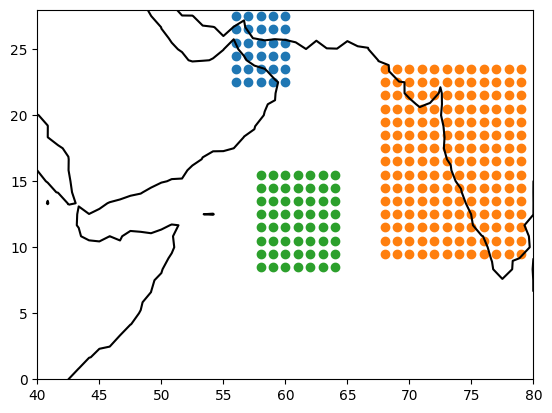

In [81]:
## SOO

plt.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k')
plt.xlim(40,80)
plt.ylim(0,28)

xx,yy=np.meshgrid(lonn[26:31], latt[28:]-GS/2)
plt.scatter(xx, yy)


xx,yy=np.meshgrid(lonn[38:50], latt[15:30]-GS/2)
plt.scatter(xx, yy)


xx,yy=np.meshgrid(lonn[28:35], latt[14:22]-GS/2)
plt.scatter(xx, yy)

#### Fig bias mwt

In [17]:
# grid 3d for 3d variables (2d + time)
def grid_lat_3dfsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).count() #,dim='profile_num')
    
def grid_lon_3d_fsum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dfsum)
    
    
def grid_var_3dfltsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_fsum)
    return var


#####333


df_grid_mwtop_f_month_count=grid_var_3dfltsum(df_mw_top.top_mwl_f*mask_thic*mask_pres, clim='season', gs=1) ##3min

mask_winter1=df_grid_mwtop_f_month_count.where(df_grid_mwtop_f_month_count!=0, np.nan)
mask_winter=mask_winter1.where(mask_winter1<3, np.nan)

crosseshatches=[mask_winter[0], mask_winter[2], mask_winter[1], mask_winter[3]]

0it [00:00, ?it/s]

29
(34.227053140096615, 5.772338415170065)
(24.948709642587197, 6.124474654308702)
eas (19.203703703703702, 1.3172311461946609)
sas (25.767676767676768, 5.445671794343186)
26
(24.099415204678365, 5.11230531902277)
(19.092122751322755, 3.1067088720259513)
eas (17.299145299145298, 1.8321724453981891)
sas (17.813131313131315, 2.2029814415730127)
26
(17.470370370370368, 2.3334097577137394)
(25.394301994301998, 3.502370687611185)
eas (22.096296296296295, 4.864253305439462)
sas (25.938271604938272, 3.1012237555838893)
29
(16.51851851851852, 1.385799032138497)
(18.684303350970016, 2.2517154838854734)
eas (17.299145299145298, 2.14276078247455)
sas (19.34567901234568, 1.96327352151618)


0it [00:00, ?it/s]

0
(8.264705882352942, 8.104293163974358)
(3.8143259719346676, 4.689159077562673)
soo (21.66666666666667, 1.8888888888888875)
eas (-0.4333333333333331, 5.012441311500273)
sas (7.500000000000001, 0.7663773534154538)
1
(-7.916666666666667, 6.39156546188005)
(-6.487156511350061, 3.262571272396327)
soo (3.1111111111111107, 6.727133192352766)
eas (-8.256410256410255, 2.3662919658642587)
sas (-6.43939393939394, 1.4178702642039092)
2
(-9.825617283950619, 6.019911796627162)
(7.828816621499548, 4.037997823081942)
soo (-4.0, 0.0)
eas (1.6728395061728392, 4.836722082776766)
sas (8.14236111111111, 3.5951553881105744)
3
(-1.9444444444444444, 1.722222222222222)
(1.1136220966729438, 3.8496880203923785)
soo (nan, nan)
eas (-2.9166666666666665, 2.912519096883647)
sas (2.8666666666666667, 2.671276879061595)


0it [00:00, ?it/s]

29
(-39.44570707070707, 21.071416491599532)
(-19.338252314814813, 7.991773042477069)
soo (-18.833333333333332, 15.848303514251466)
eas (-11.381558641975309, 2.6809837743082907)
sas (-22.037280701754387, 10.638268625735359)
26
(-38.89864864864865, 14.682228265350084)
(-11.714291135397692, 5.836219639364285)
soo (-53.35185185185185, 6.144242400625208)
eas (-7.126068376068376, 1.5149369219759383)
sas (-14.236559139784948, 5.243258035529784)
26
(-16.922619047619044, 5.925111145150655)
(-6.051356589147287, 4.9497614472223095)
soo (-16.86111111111111, 6.12074156996153)
eas (0.2337962962962965, 3.2869873170470223)
sas (-6.671296296296297, 5.186982988598044)
29
(-4.018518518518518, 0.0)
(-5.381799768518518, 2.4336643710565093)
soo (nan, nan)
eas (-3.271464646464646, 1.1068710708538338)
sas (-6.535734953703704, 1.7126099307658869)


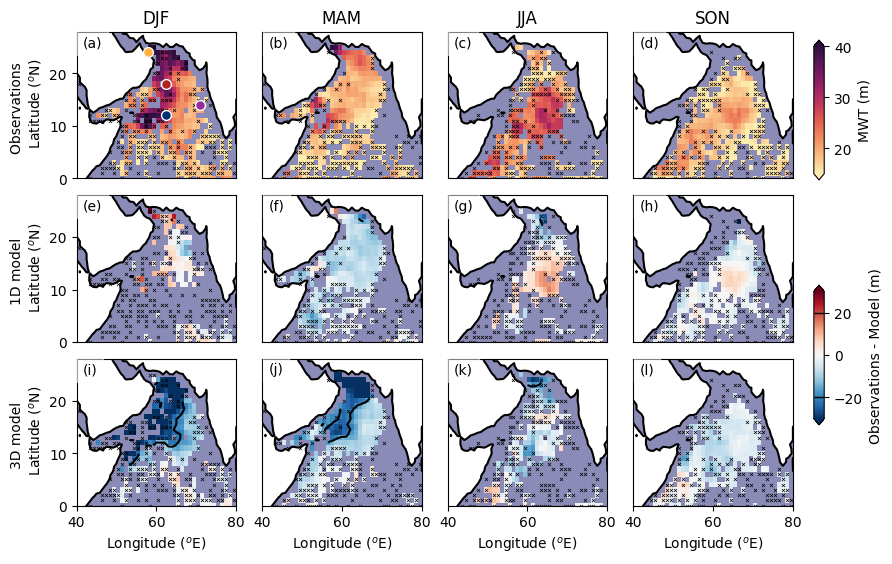

In [18]:
xx,yy=8,8
fig_sx, fig_sy=8,7

fig = plt.figure(figsize=(fig_sx, fig_sy), constrained_layout=True)
gs = GridSpec(xx,yy, figure=fig)
titles=df_grid_mwt_f_season.season.values

msk_availability_data_season=np.isfinite((percentage0_seas+percentage1_seas)).astype(float)
msk_availability_data_season=((percentage0_seas+percentage1_seas)>0).astype(float)
cmap_data_availability_ = cl.ListedColormap(['midnightblue', 'midnightblue'])

MWT_array=[]
data_plt=(df_grid_mwt_f_season.values)
axis_=[]
for i,m in tqdm(enumerate([0,2,1,3])):
    # ax = fig.add_subplot(gs[ i % yy,i // yy])
    ax = fig.add_subplot(gs[0:2, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    
    mskk_availability_data_m=msk_availability_data_season.isel(month_bins=i)
    ax.pcolormesh(lonn, latt-GS/2, (mskk_availability_data_m.where(mskk_availability_data_m==0, 0)).T, cmap=cmap_data_availability_, alpha=0.5)

    axis_.append(ax)
    ax.set_title(titles[m])
    data_m=data_plt[m]
    mks=np.isfinite(data_m.T).astype(float)
    mks[mks==0]=np.nan
    
    to_plt=pd.DataFrame(data_m.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks
    cbmwt=plt.pcolormesh(lonn, latt-GS/2, to_plt, cmap=cmo.matter, vmin=15, vmax=40)
    MWT_array.append(to_plt)
   
    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)
    
    mask_hatches=crosseshatches[i]
    non_nan_coords = mask_hatches.stack(z=("latitude_f_bins", "longitude_f_bins")).dropna("z")
    y_points, x_points=non_nan_coords['latitude_f_bins'].values.astype(int), non_nan_coords['longitude_f_bins'].values.astype(int)
    for i, j in zip(x_points, y_points):
        # print(x[i])
        plt.scatter( lonn[i]+GS/2,latt[j], s=5,marker='x', c='k', linewidth=0.5)

    print(i)
    mskss=(~np.isfinite(mask_hatches/mask_hatches)).astype(float).where((~np.isfinite(mask_hatches/mask_hatches)).astype(float)==1, np.nan)
    lol1=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[25:,15:-10]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[25:, 15:-10])
    lol2=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:25,15:-10]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:25,15:-10])
    print(lol1)
    print(lol2)
    
    loloman=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:30,38:50]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:30,38:50])
    print('eas', loloman )
    
    loloman=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[14:18,30:35]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[14:18,30:35])
    print('sas', loloman )


data_plt=df_mwt_gotm_grid 
df_plt=df_grid_mwt_f_season.rename({'longitude_f_bins':'longitude_bins', 'latitude_f_bins':'latitude_bins'})-data_plt

bias_MWT_1D_array=[]
for i,m in tqdm(enumerate([0,2,1,3])):
    # ax = fig.add_subplot(gs[ i % yy,i // yy])
    ax = fig.add_subplot(gs[2:4, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+4] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    mskk_availability_data_m=msk_availability_data_season.isel(month_bins=i)
    # ax.pcolormesh(lonn, latt-GS/2, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)
    ax.pcolormesh(lonn, latt-GS/2, (mskk_availability_data_m.where(mskk_availability_data_m==0, 0)).T, cmap=cmap_data_availability_, alpha=0.5)

    axis_.append(ax)

    df_plt_=df_plt[m].values
    mks=np.isfinite(df_plt_.T).astype(float)
    mks[mks==0]=np.nan
    to_plt=pd.DataFrame(df_plt_.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks
    
    bias_MWT_1D_array.append(to_plt)
    
    plt.pcolormesh(lonn, latt-GS/2, to_plt, vmin=-30, vmax=30 ,cmap=br)

    plt.contour(lonn[:-1], latt[:-1]-GS/2, to_plt,  levels=[-20,20], colors='k', linestyles='-')
    # plt.contour(lonn[:-1], latt[:-1]-GS/2, to_plt,  levels=[-10,10], colors='k', linestyles=':')
   
    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)
    print(i)
    
    mask_hatches=crosseshatches[i]
    non_nan_coords = mask_hatches.stack(z=("latitude_f_bins", "longitude_f_bins")).dropna("z")
    y_points, x_points=non_nan_coords['latitude_f_bins'].values.astype(int), non_nan_coords['longitude_f_bins'].values.astype(int)
    for i, j in zip(x_points, y_points):
        # print(x[i])
        plt.scatter( lonn[i]+GS/2,latt[j], s=5,marker='x', c='k', linewidth=0.5)

    mskss=(~np.isfinite(mask_hatches/mask_hatches)).astype(float).where((~np.isfinite(mask_hatches/mask_hatches)).astype(float)==1, np.nan)
    lol1=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[25:,15:-10]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[25:, 15:-10])
    lol2=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:20,15:-10]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:20,15:-10])
    print(lol1)
    print(lol2)
        
    loloman=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[28:,26:31]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[28:,26:31])
    print('soo', loloman )
    loloman=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:30,38:50]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:30,38:50])
    print('eas', loloman )
    loloman=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[14:18,30:35]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[14:18,30:35])
    print('sas', loloman )

# topaz_mld=ds_topaz.mixed_layer_depth.groupby('time.season').median()
df_plt=df_grid_mwt_f_season.rename({'longitude_f_bins':'longitude_bins', 'latitude_f_bins':'latitude_bins'})-ds_all_topaz_coll_grid_mwt
bias_MWT_3D_array=[]
for i,m in tqdm(enumerate([0,2,1,3])):
    # ax = fig.add_subplot(gs[ i % yy,i // yy])
    ax = fig.add_subplot(gs[4:6, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+8] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    mskk_availability_data_m=msk_availability_data_season.isel(month_bins=i)
    # ax.pcolormesh(lonn, latt-GS/2, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)
    ax.pcolormesh(lonn, latt-GS/2, (mskk_availability_data_m.where(mskk_availability_data_m==0, 0)).T, cmap=cmap_data_availability_, alpha=0.5)

    axis_.append(ax)

    df_plt_=df_plt[m].values
    mks=np.isfinite(df_plt_.T).astype(float)
    mks[mks==0]=np.nan
    to_plt=pd.DataFrame(df_plt_.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks
    bias_MWT_3D_array.append(to_plt)
    
    plt.pcolormesh(lonn, latt-GS/2, to_plt, vmin=-30, vmax=30 ,cmap=br)

    plt.contour(lonn[:-1], latt[:-1]-GS/2, to_plt,  levels=[-20,20], colors='k', linestyles='-')
    # plt.contour(lonn[:-1], latt[:-1]-GS/2, to_plt,  levels=[-10,10], colors='k', linestyles=':')
   
    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k', lw=1)
    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0, 3000], colors='w')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)

    mask_hatches=crosseshatches[i]
    non_nan_coords = mask_hatches.stack(z=("latitude_f_bins", "longitude_f_bins")).dropna("z")
    y_points, x_points=non_nan_coords['latitude_f_bins'].values.astype(int), non_nan_coords['longitude_f_bins'].values.astype(int)
    for i, j in zip(x_points, y_points):
        # print(x[i])
        plt.scatter( lonn[i]+GS/2,latt[j], s=5,marker='x', c='k', linewidth=0.5)
        
    print(i)
    mskss=(~np.isfinite(mask_hatches/mask_hatches)).astype(float).where((~np.isfinite(mask_hatches/mask_hatches)).astype(float)==1, np.nan)
    lol1=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[25:,15:-10]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[25:, 15:-10])
    lol2=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:20,15:-10]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:20,15:-10])
    print(lol1)
    print(lol2)

        
    loloman=np.nanmean(((to_plt.T).to_numpy()).T[28:,26:31]),np.nanstd(((to_plt.T)).to_numpy().T[28:,26:31])
    print('soo', loloman )
    loloman=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:30,38:50]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[15:30,38:50])
    print('eas', loloman )
    loloman=np.nanmean(((to_plt.T).to_numpy()*mskss).to_numpy().T[14:22,30:35]),np.nanstd(((to_plt.T).to_numpy()*mskss).to_numpy().T[14:22,30:35])
    print('sas', loloman )

    
cbar_ax = fig.add_axes([1.01, 0.75, 0.013, 0.2])  # left, bottom, width, height
cbar = plt.colorbar(cbmwt, cax=cbar_ax,  extend='both')
cbar.set_label('MWT (m)')

cbar_ax = fig.add_axes([1.01, 0.4, 0.013, 0.2])  # left, bottom, width, height
cbar = plt.colorbar(cb3, cax=cbar_ax,  extend='both')
cbar.set_label('Observations - Model (m)')
ax = cbar.ax
xmin, xmax = ax.get_xlim()
ax.hlines([-20,20], xmin, xmax, colors=['black'], linewidth=1)

axis_[0].set_ylabel('Observations \n Latitude ($^o$N)')

for i in range(8):
    axis_[i].set_xticks([])

for i in range(1,4):
    axis_[i].set_yticks([])
for i in range(5,8):
    axis_[i].set_yticks([])    

for i in range(9,12):
    axis_[i].set_yticks([])    
    
    
axis_[4].set_ylabel('1D model \n Latitude ($^o$N)')
axis_[8].set_ylabel('3D model \n Latitude ($^o$N)')

for i in range(8, len(axis_)):
    axis_[i].set_xlabel('Longitude ($^o$E)')

    
GoO=[24, 58]
SAS=[12,62.5]
# UPW=[18, 58]
EAS=[20,68]
SEAS=[14,71]
CAS=[18,62.5]

regions=[GoO, SAS, SEAS, CAS]
colors_regions=["#ffb03f",
"#002f74",
"#962d9e",
"firebrick"]
for m, region in enumerate(regions):
    axis_[0].scatter(region[1], region[0], zorder=100, c=colors_regions[m], s=50, edgecolor='w', linewidth=1)
plt.savefig('Figures/Figure7_MWT.png', dpi=600, bbox_inches='tight')

In [66]:
7/18, 8/18

(0.3888888888888889, 0.4444444444444444)

In [106]:
8/26

0.3076923076923077

In [144]:
# bias_MLD_1D_array

i=2
mskkkito=(~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float).where((~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float)==1, np.nan)

print('1d model sas summer to fall')
# print('mean bias 1D winter MLD / mean thickness', (np.nanmean((bias_MLD_1D_array[0].to_numpy().T).T[25:,15:-10])/np.nanmean((bias_MWT_1D_array[1].to_numpy().T*mskkkito).T[25:,15:-10]))*100)
print(np.nanmean((bias_MLD_1D_array[2].to_numpy().T).T[15:20,15:-10]) / np.nanmean((bias_MWT_1D_array[2].to_numpy().T*mskkkito).T[15:20,15:-10])), print(np.nanstd((bias_MLD_1D_array[2].to_numpy().T).T[15:20,15:-10]) / np.nanmean((bias_MWT_1D_array[2].to_numpy().T*mskkkito).T[15:20,15:-10]))
print('3d model sas summer to fall')
np.nanmean((bias_MLD_3D_array[2].to_numpy().T).T[15:20,15:-15])/ np.nanmean((bias_MWT_3D_array[2].to_numpy().T*mskkkito).T[15:20,15:-10]), np.nanstd((bias_MLD_3D_array[2].to_numpy().T).T[15:20,15:-10])/ np.nanmean((bias_MWT_3D_array[2].to_numpy().T*mskkkito).T[15:20,15:-10])

1d model sas summer to fall
0.4252570241735419
1.81593055648639
3d model sas summer to fall


(2.0813242791764277, -1.2451876462300004)

In [143]:
# bias_MLD_1D_array

i=1
mskkkito=(~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float).where((~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float)==1, np.nan)

print('1d model nas winter to spring')
print(np.nanmean((bias_MLD_1D_array[0].to_numpy().T).T[25:,15:-10]) / np.nanmean((bias_MWT_1D_array[1].to_numpy().T*mskkkito).T[25:,15:-10]), np.nanstd((bias_MLD_1D_array[0].to_numpy().T).T[25:,15:-10])/ np.nanmean((bias_MWT_1D_array[1].to_numpy().T*mskkkito).T[25:,15:-10]))

print('3d model nas winter to spring')
(np.nanmean((bias_MLD_3D_array[0].to_numpy().T*mskkkito).T[25:,15:-10]) / np.nanmean((bias_MWT_3D_array[1].to_numpy().T*mskkkito).T[25:,15:-10])), (np.nanstd((bias_MLD_3D_array[0].to_numpy().T*mskkkito).T[25:,15:-10]) / np.nanmean((bias_MWT_3D_array[1].to_numpy().T*mskkkito).T[25:,15:-10]))


1d model nas winter to spring
3.468048910154173 -2.20438530060443
3d model nas winter to spring


(0.8571201056701545, -0.20371559588083088)

In [86]:
print('NAS')
for i in range(4):
    mskkkito=(~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float).where((~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float)==1, np.nan)
    print('mean bias 1D / mean thickness', (np.nanmean((bias_MWT_1D_array[i].to_numpy().T*mskkkito).T[25:,15:-10])/np.nanmean((MWT_array[i].to_numpy().T*mskkkito).T[25:,15:-10]))*100)
    print('std bias 1D / mean thickness', (np.nanstd((bias_MWT_1D_array[i].to_numpy().T*mskkkito).T[25:,15:-10])/np.nanmean((MWT_array[i].to_numpy().T*mskkkito).T[25:,15:-10]))*100)

NAS
mean bias 1D / mean thickness 24.14670596537839
std bias 1D / mean thickness 23.67803366185875
mean bias 1D / mean thickness -32.850036398932296
std bias 1D / mean thickness 26.521662071863343
mean bias 1D / mean thickness -56.24160836689989
std bias 1D / mean thickness 34.45783729254471
mean bias 1D / mean thickness -11.771300448430493
std bias 1D / mean thickness 10.426008968609866


In [87]:
print('SAS')
for i in range(4):
    mskkkito=(~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float).where((~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float)==1, np.nan)
    print('mean bias 1D / mean thickness', (np.nanmean((bias_MWT_1D_array[i].to_numpy().T*mskkkito).T[10:25,15:-10])/np.nanmean((MWT_array[i].to_numpy().T*mskkkito).T[10:25,15:-10]))*100)
    print('std bias 1D / mean thickness', (np.nanstd((bias_MWT_1D_array[i].to_numpy().T*mskkkito).T[10:25,15:-10])/np.nanmean((MWT_array[i].to_numpy().T*mskkkito).T[10:25,15:-10]))*100)

SAS
mean bias 1D / mean thickness 4.042750529602242
std bias 1D / mean thickness 26.884451369450897
mean bias 1D / mean thickness -37.92158255495433
std bias 1D / mean thickness 17.39612843550433
mean bias 1D / mean thickness 21.87062637190537
std bias 1D / mean thickness 20.880539932948007
mean bias 1D / mean thickness -5.113944661139096
std bias 1D / mean thickness 20.04871787991914


In [83]:
print('NAS')
for i in range(4):
    mskkkito=(~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float).where((~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float)==1, np.nan)
    print('mean bias 3D / mean thickness', (np.nanmean((bias_MWT_3D_array[i].to_numpy().T*mskkkito).T[25:,15:-10])/np.nanmean((MWT_array[i].to_numpy().T*mskkkito).T[25:,15:-10]))*100)
    print('std bias 3D / mean thickness', (np.nanstd((bias_MWT_3D_array[i].to_numpy().T*mskkkito).T[25:,15:-10])/np.nanmean((MWT_array[i].to_numpy().T*mskkkito).T[25:,15:-10]))*100)


NAS
mean bias 3D / mean thickness -115.24716109578496
std bias 3D / mean thickness 61.563630398886424
mean bias 3D / mean thickness -161.40909776556464
std bias 3D / mean thickness 60.923587318002035
mean bias 3D / mean thickness -96.86468396983554
std bias 3D / mean thickness 33.91520053404022
mean bias 3D / mean thickness -24.327354260089685
std bias 3D / mean thickness 0.0


In [85]:
print('SAS')
for i in range(4):
    mskkkito=(~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float).where((~np.isfinite(crosseshatches[i]/crosseshatches[i])).astype(float)==1, np.nan)
    print('mean bias 3D / mean thickness', (np.nanmean((bias_MWT_3D_array[i].to_numpy().T*mskkkito).T[10:25,15:-10])/np.nanmean((MWT_array[i].to_numpy().T*mskkkito).T[10:25,15:-10]))*100)
    print('std bias 3D / mean thickness', (np.nanstd((bias_MWT_3D_array[i].to_numpy().T*mskkkito).T[10:25,15:-10])/np.nanmean((MWT_array[i].to_numpy().T*mskkkito).T[10:25,15:-10]))*100)


SAS
mean bias 3D / mean thickness -80.5436221926671
std bias 3D / mean thickness 46.832691088512604
mean bias 3D / mean thickness -62.98740172207804
std bias 3D / mean thickness 36.229685141656375
mean bias 3D / mean thickness -20.966285951842284
std bias 3D / mean thickness 20.738420720598924
mean bias 3D / mean thickness -26.62362357383719
std bias 3D / mean thickness 16.22871081374842


24.099415204678365

In [50]:
## EXTRA

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

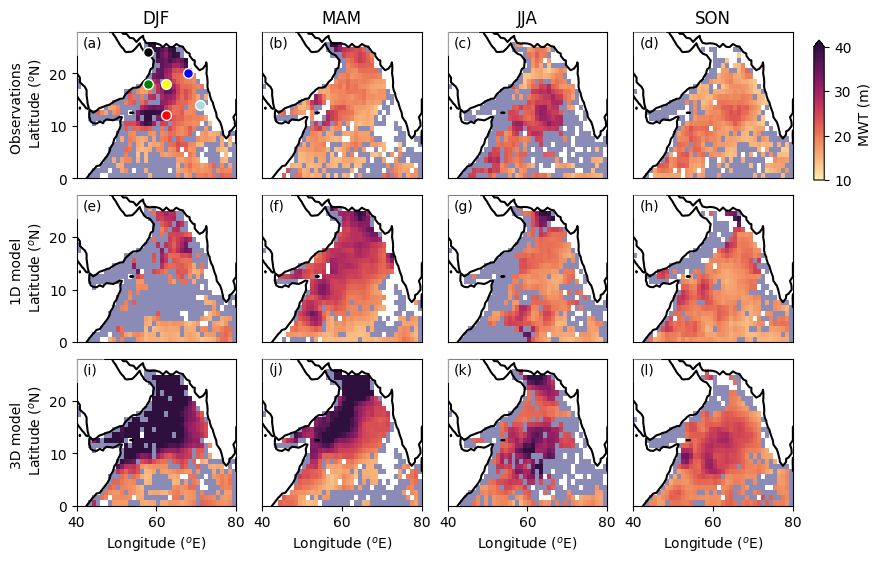

In [119]:
xx,yy=8,8
fig_sx, fig_sy=8,7

# from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(fig_sx, fig_sy), constrained_layout=True)
gs = GridSpec(xx,yy, figure=fig)
titles=df_grid_mwt_f_season.season.values

msk_availability_data_season=np.isfinite((percentage0_seas+percentage1_seas)).astype(float)
msk_availability_data_season=((percentage0_seas+percentage1_seas)>0).astype(float)
cmap_data_availability_ = cl.ListedColormap(['white', 'midnightblue'])

data_plt=(df_grid_mwt_f_season.values)
axis_=[]
for i,m in tqdm(enumerate([0,2,1,3])):
    # ax = fig.add_subplot(gs[ i % yy,i // yy])
    ax = fig.add_subplot(gs[0:2, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    
    
    mskk_availability_data_m=msk_availability_data_season.isel(month_bins=i)
    ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

    axis_.append(ax)
    ax.set_title(titles[m])
    data_m=data_plt[m]
    # cb1=ax.pcolormesh(lonn, latt, data_m.T, cmap=cmo.matter, vmin=10, vmax=40)
    # cb1=ax.pcolormesh(lonn, latt,  pd.DataFrame(data_m.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean(), cmap=cmo.matter, vmin=10, vmax=40)
    mks=np.isfinite(data_m.T).astype(float)
    mks[mks==0]=np.nan
    cb1=plt.pcolormesh(lonn, latt, pd.DataFrame(data_m.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks, cmap=cmo.matter, vmin=10, vmax=40)

   
    # ax.contourf(np.arange(40,76,1), np.arange(0,28,1), grid2d(data_m.longitude.values.flatten(), data_m.latitude.values.flatten(), data_m.values.flatten(), xi=np.arange(40,76,1), yi=np.arange(0,28,1))[0], levels=[VMIN, VAX_], colors='green', alpha=0.9)
    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)


# data_plt=df_mwt_gotm_grid 
df_plt=df_mwt_gotm_grid

for i,m in tqdm(enumerate([0,2,1,3])):
    # ax = fig.add_subplot(gs[ i % yy,i // yy])
    ax = fig.add_subplot(gs[2:4, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+4] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    mskk_availability_data_m=msk_availability_data_season.isel(month_bins=i)
    ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

    axis_.append(ax)
    # df_mld_topaz_i=topaz_mld.isel(season=i)    
    # df_plt=df_mld_topaz_i.interp_like('latitude'==df_mld_float_i.latitude).interp_like('longitude'==df_mld_float_i.longitude)
    
    # df_mld_float_i=df_grid_mld_f_season[i]
    # df_mld_float_i['latitude']=('latitude_f_bins', latt[:-1])
    # df_mld_float_i['longitude']=('longitude_f_bins', lonn[:-1])
    # df_mld_float_i=df_mld_float_i.swap_dims({'latitude_f_bins':'latitude', 'longitude_f_bins':'longitude'})
    # df_plt_=df_plt.isel(season=i)
    df_plt_=df_plt[m].values
    mks=np.isfinite(df_plt_.T).astype(float)
    mks[mks==0]=np.nan
    plt.pcolormesh(lonn, latt, pd.DataFrame(df_plt_.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks, cmap=cmo.matter, vmin=10, vmax=40)

   
    # cb3=ax.pcolormesh(lonn, latt,df_plt_.T, vmin=-30, vmax=30 ,cmap=br)
    
    # cb=ax.pcolormesh(lonn, latt, data_m.T, vmin=-30, vmax=30, cmap=cmo.balance)
    # ax.contourf(np.arange(40,76,1), np.arange(0,28,1), grid2d(data_m.longitude.values.flatten(), data_m.latitude.values.flatten(), data_m.values.flatten(), xi=np.arange(40,76,1), yi=np.arange(0,28,1))[0], levels=[VMIN, VAX_], colors='green', alpha=0.9)
    ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)


# topaz_mld=ds_topaz.mixed_layer_depth.groupby('time.season').median()
df_plt=ds_all_topaz_coll_grid_mwt
 
for i,m in tqdm(enumerate([0,2,1,3])):
    # ax = fig.add_subplot(gs[ i % yy,i // yy])
    ax = fig.add_subplot(gs[4:6, i*2:i*2+2])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+8] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    mskk_availability_data_m=msk_availability_data_season.isel(month_bins=i)
    ax.pcolormesh(lonn, latt, (mskk_availability_data_m).T, cmap=cmap_data_availability_, alpha=0.5)

    axis_.append(ax)

    df_plt_=df_plt[m].values
    mks=np.isfinite(df_plt_.T).astype(float)
    mks[mks==0]=np.nan
    plt.pcolormesh(lonn, latt, pd.DataFrame(df_plt_.T).interpolate(limit=1, axis=1).interpolate(limit=1, axis=0).rolling(3, axis=0, center=True).mean().rolling(3, axis=1, center=True).mean()*mks, cmap=cmo.matter, vmin=10, vmax=40)

       ax.contour(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[0], colors='k')
    ax.set_xlim(40,80)
    ax.set_ylim(0,28)


cbar_ax = fig.add_axes([1.01, 0.75, 0.013, 0.2])  # left, bottom, width, height
cbar = plt.colorbar(cb1, cax=cbar_ax,  extend='max')
cbar.set_label('MWT (m)')


axis_[0].set_ylabel('Observations \n Latitude ($^o$N)')

for i in range(8):
    axis_[i].set_xticks([])

for i in range(1,4):
    axis_[i].set_yticks([])
for i in range(5,8):
    axis_[i].set_yticks([])    

for i in range(9,12):
    axis_[i].set_yticks([])    
    
# for i in range(13,16):
#     axis_[i].set_yticks([])    
    
    
axis_[4].set_ylabel('1D model \n Latitude ($^o$N)')
axis_[8].set_ylabel('3D model \n Latitude ($^o$N)')
# axis_[12].set_ylabel('MWT bias \n Latitude')

for i in range(8, len(axis_)):
    axis_[i].set_xlabel('Longitude ($^o$E)')

    
GoO=[24, 58]
SAS=[12,62.5]
UPW=[18, 58]
EAS=[20,68]
SEAS=[14,71]
CAS=[18,62.5]

regions=[GoO, SAS, UPW, EAS, SEAS, CAS]
colors_regions=['k', 'r', 'green', 'b', 'lightblue', 'yellow']

for m, region in enumerate(regions):
    axis_[0].scatter(region[1], region[0], zorder=100, c=colors_regions[m], s=50, edgecolor='w', linewidth=1)